## **Exploración de Sentencias - Corte Constitucional**

## **Importación de librerías**

In [1]:
# manipulación de datos
import pandas as pd
import numpy as np

# conveniencias
import tqdm
import os

# proceso de texto
import re
import nltk
import spacy

# procesamiento paralelo
from multiprocessing import Pool

# machine learning
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_distances
from gensim.test.utils import datapath
from gensim.models import FastText

In [2]:
nltk.download('stopwords')
nlp = spacy.load("es_core_news_md")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/caicardo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## **Definición de funciones**

In [3]:
def preprocessor(text):
    """
    preprocesador de texto
    """
    if not isinstance(text, str):
        return ""
    punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~ºª'''
    for char in punctuations:
        text = text.replace(char, " ")
    
    text = re.sub("\s+", " ", text)
    text = text.strip().lower()
    text = re.sub("\d+", "<NUM>", text)
    return text

In [4]:
def preprocessor_sentences(text):
    """
    preprocesador de texto con separación de frases por línea.
    """
    if not isinstance(text, str):
        return ""
    punctuations = '''!()-[]{};:'"\,<>/?@#$%^&*_~ºª'''
    for char in punctuations:
        text = text.replace(char, " ")
    text = re.sub("\d+", "<NUM>", text)
    text = text.replace("\n\n", "<FIN>")
    text = text.replace(".", "<FIN>")
    text = re.sub("\s+", " ", text)
    text = text.replace("<FIN>", "\n")
    text = "".join([c for c in text if str.isprintable(c) or c=="\n" or c=="."])
    text = re.sub("[\n\r]+", "\n", text)
    text = text.lower()
    text = text.strip("\n ")
    return text

In [5]:
def wv_vectorizer(text):
    """
    Calcula el vector promedio de las palabras de la frase.
    """
    text = preprocessor(text)
    vec_list = []
    for word in [w for w in text.split() if w not in es_stopwords]:
        vec_list.append(model.wv[word])
    vec_list = np.array(vec_list)
    vec = np.mean(vec_list, axis=0)
    return vec

In [6]:
def remove_stopwords(text):
    tokens = text.split()
    out = " ".join([word for word in tokens if word not in es_stopwords])
    return out

In [7]:
def lemmatize(text):
    nlp_tokens = nlp(text)
    lemma = [w.lemma_ for w in nlp_tokens]
    lemma = " ".join(lemma)
    return lemma
    

## **Configuración**

In [8]:
RANDOM_STATE = 42
N_TOP_DOCS = 5
CARACTERES = 500

In [9]:
es_stopwords = nltk.corpus.stopwords.words("spanish")

In [10]:
es_stopwords.remove("no")

In [11]:
es_stopwords.append("<NUM>")

## **Lectura de datos**

In [12]:
df = pd.read_csv("data/documents_V1_2/documents_V1_2.csv")

In [14]:
print(df.columns)

Index(['INDEX', 'DOCUMENT_TYPE', 'LINK', 'DOCUMENT', 'DOCUMENT_WITH_SIGNS',
       'DOCUMENT_CLEAN'],
      dtype='object')


In [15]:
df["tipo"] = [x.strip()[0] for x in df.INDEX]

In [16]:
df.head()

,INDEX,DOCUMENT_TYPE,LINK,DOCUMENT,DOCUMENT_WITH_SIGNS,DOCUMENT_CLEAN,tipo
0,A107-21,A,https://www.corteconstitucional.gov.co/Relator...,auto 10721\n \n \nreferencia: expediente t-7.9...,auto 10721 referencia: expediente t-7.909.170...,auto 10721 referencia expediente t 7 909 170 a...,A
1,A106-21,A,https://www.corteconstitucional.gov.co/Relator...,auto 10621\n \n \nreferencia: expediente t-6.8...,auto 10621 referencia: expediente t-6.839.494...,auto 10621 referencia expediente t 6 839 494 a...,A
2,A092-21,A,https://www.corteconstitucional.gov.co/Relator...,auto 09221\n \n \nreferencia: respuesta a la s...,auto 09221 referencia: respuesta a la solicit...,auto 09221 referencia respuesta a la solicitud...,A
3,A091-21,A,https://www.corteconstitucional.gov.co/Relator...,auto 09121\n \n \nreferencia: requerimiento al...,auto 09121 referencia: requerimiento al minis...,auto 09121 referencia requerimiento al ministr...,A
4,A090-21,A,https://www.corteconstitucional.gov.co/Relator...,auto 09021\n \n \nreferencia: expediente t- 7....,auto 09021 referencia: expediente t- 7.185.42...,auto 09021 referencia expediente t 7 185 421 a...,A


In [17]:
df.tipo.value_counts()

T    18804
A     8739
C     6543
S      391
Name: tipo, dtype: int64

## **Preprocesamiento de texto (para TF-IDF)**

No es necesario volver a preprocesar los datos, se deja el código para referencia y replicación

In [18]:
%%time
with Pool(8) as my_pool:
    pp_list = my_pool.map(preprocessor, df.DOCUMENT.values)

CPU times: user 5.17 s, sys: 4.43 s, total: 9.6 s
Wall time: 20.7 s


In [19]:
df["pp"] = pp_list

In [20]:
df.head()

,INDEX,DOCUMENT_TYPE,LINK,DOCUMENT,DOCUMENT_WITH_SIGNS,DOCUMENT_CLEAN,tipo,pp
0,A107-21,A,https://www.corteconstitucional.gov.co/Relator...,auto 10721\n \n \nreferencia: expediente t-7.9...,auto 10721 referencia: expediente t-7.909.170...,auto 10721 referencia expediente t 7 909 170 a...,A,auto <NUM> referencia expediente t <NUM> <NUM>...
1,A106-21,A,https://www.corteconstitucional.gov.co/Relator...,auto 10621\n \n \nreferencia: expediente t-6.8...,auto 10621 referencia: expediente t-6.839.494...,auto 10621 referencia expediente t 6 839 494 a...,A,auto <NUM> referencia expediente t <NUM> <NUM>...
2,A092-21,A,https://www.corteconstitucional.gov.co/Relator...,auto 09221\n \n \nreferencia: respuesta a la s...,auto 09221 referencia: respuesta a la solicit...,auto 09221 referencia respuesta a la solicitud...,A,auto <NUM> referencia respuesta a la solicitud...
3,A091-21,A,https://www.corteconstitucional.gov.co/Relator...,auto 09121\n \n \nreferencia: requerimiento al...,auto 09121 referencia: requerimiento al minis...,auto 09121 referencia requerimiento al ministr...,A,auto <NUM> referencia requerimiento al ministr...
4,A090-21,A,https://www.corteconstitucional.gov.co/Relator...,auto 09021\n \n \nreferencia: expediente t- 7....,auto 09021 referencia: expediente t- 7.185.42...,auto 09021 referencia expediente t 7 185 421 a...,A,auto <NUM> referencia expediente t <NUM> <NUM>...


**Guardar datos preprocesados**

In [23]:
df.to_csv("documents_pp.csv")

In [21]:
# Ejemplo
df.iloc[0].pp

'auto <NUM> referencia expediente t <NUM> <NUM> <NUM> ac acción de tutela promovida por carmen alicia rodríguez berrío y otros contra holding inmobiliaria y otros asunto solicitud de cumplimiento de la sentencia t <NUM> de <NUM> peticionaria carmen alicia rodríguez berrío magistrada sustanciadora gloria stella ortiz delgado bogotá d c nueve <NUM> de marzo de dos mil veintiuno <NUM> la suscrita magistrada sustanciadora en ejercicio de sus competencias constitucionales y legales profiere el presente auto con fundamento en los siguientes antecedentes <NUM> el pasado <NUM> de enero la sala sexta de revisión profirió la sentencia t <NUM> de <NUM> <NUM> en el caso particular de la señora carmen alicia dicha providencia concedió el amparo de los derechos a la estabilidad laboral reforzada y al mínimo vital <NUM> en consecuencia esta corporación le ordenó a holding inmobiliaria reintegrar a la peticionaria al trabajo que desempeñaba en la empresa lo anterior porque declaró ineficaz el despido 

In [22]:
remove_stopwords(df.iloc[0].pp)

'auto referencia expediente t ac acción tutela promovida carmen alicia rodríguez berrío holding inmobiliaria asunto solicitud cumplimiento sentencia t peticionaria carmen alicia rodríguez berrío magistrada sustanciadora gloria stella ortiz delgado bogotá d c nueve marzo dos mil veintiuno suscrita magistrada sustanciadora ejercicio competencias constitucionales legales profiere presente auto fundamento siguientes antecedentes pasado enero sala sexta revisión profirió sentencia t caso particular señora carmen alicia dicha providencia concedió amparo derechos estabilidad laboral reforzada mínimo vital consecuencia corporación ordenó holding inmobiliaria reintegrar peticionaria trabajo desempeñaba empresa anterior declaró ineficaz despido además ordenó reconocerle indemnización prevista inciso artículo ley prestaciones salarios aportes dejados percibir igual forma ordenó positiva arl pagarle incapacidades pendientes mediante escritos febrero marzo actora solicitó corte constitucional cumpl

In [26]:
%%time
lemmatize(remove_stopwords(df.iloc[0].pp))

CPU times: user 45.9 ms, sys: 1.29 ms, total: 47.2 ms
Wall time: 48.6 ms


'auto referencia expediente t ac acción tutelar promovido carmen alicio rodríguez berrío holding inmobiliario asunto solicitud cumplimiento sentencia t peticionario carmen alicio rodríguez berrío magistrado sustanciadoro gloria stello ortiz delgado bogotá d c nueve marzo dos mil veintiuno suscrito magistrada sustanciadoro ejercicio competencia constitucional legal proferir presente auto fundamento siguiente antecedente pasado enero sala sexto revisión proferir sentencia t caso particular señora carmen alicio dicho providencia conceder amparo derecho estabilidad laboral reforzado mínimo vital consecuencia corporación ordenar holding inmobiliario reintegrar peticionaria trabajo desempeñar empresa anterior declarar ineficaz despido además ordenar reconocer él indemnización previsto inciso artículo ley prestación salario aporte dejado percibir igual forma ordenar positiva arl pagar él incapacidad pendiente mediante escrito febrero marzo actoro solicitar corte constitucional cumplimiento de

In [27]:
df[df.DOCUMENT!=df.DOCUMENT]

,INDEX,DOCUMENT_TYPE,LINK,DOCUMENT,DOCUMENT_WITH_SIGNS,DOCUMENT_CLEAN,tipo,pp
6286,A348-06,A,https://www.corteconstitucional.gov.co/Relator...,NaN,NaN,NaN,A,
6379,A250-06,A,https://www.corteconstitucional.gov.co/Relator...,NaN,NaN,NaN,A,


In [28]:
df[df.pp==""]

,INDEX,DOCUMENT_TYPE,LINK,DOCUMENT,DOCUMENT_WITH_SIGNS,DOCUMENT_CLEAN,tipo,pp
6286,A348-06,A,https://www.corteconstitucional.gov.co/Relator...,NaN,NaN,NaN,A,
6379,A250-06,A,https://www.corteconstitucional.gov.co/Relator...,NaN,NaN,NaN,A,
29382,T-1020-99,T,https://www.corteconstitucional.gov.co/Relator...,\n,,,T,
29385,T-1017-99,T,https://www.corteconstitucional.gov.co/Relator...,\n,,,T,
29386,T-1016-99,T,https://www.corteconstitucional.gov.co/Relator...,\n,,,T,
29387,T-1015-99,T,https://www.corteconstitucional.gov.co/Relator...,\n,,,T,
29388,T-1014-99,T,https://www.corteconstitucional.gov.co/Relator...,\n,,,T,
29389,T-1013-99,T,https://www.corteconstitucional.gov.co/Relator...,\n,,,T,
29390,T-1012-99,T,https://www.corteconstitucional.gov.co/Relator...,\n,,,T,
29391,T-1011-99,T,https://www.corteconstitucional.gov.co/Relator...,\n,,,T,


In [29]:
df = df[df.pp!=""].copy()

## LDA

In [30]:
from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamulticore import LdaMulticore

In [32]:
df["char_len"] = [len(x) for x in df.pp.values]

In [34]:
df[df.char_len>1000000]

,INDEX,DOCUMENT_TYPE,LINK,DOCUMENT,DOCUMENT_WITH_SIGNS,DOCUMENT_CLEAN,tipo,pp,char_len
10358,C-080-18,C,https://www.corteconstitucional.gov.co/Relator...,sentencia c-08018\n \ninstrumentos para facili...,sentencia c-08018 instrumentos para facilitar ...,sentencia c 08018 instrumentos para facilitar ...,C,sentencia c <NUM> instrumentos para facilitar ...,2480010
10362,C-073-18,C,https://www.corteconstitucional.gov.co/Relator...,sentencia\r\nc-07318 \n \ninstrumentos para fa...,sentencia c-07318 instrumentos para facilitar...,sentencia c 07318 instrumentos para facilitar ...,C,sentencia c <NUM> instrumentos para facilitar ...,1104883
10407,C-007-18,C,https://www.corteconstitucional.gov.co/Relator...,\nsentencia\r\nc-00718\n \ninstrumentos\r\npa...,sentencia c-00718 instrumentos para facilitar...,sentencia c 00718 instrumentos para facilitar...,C,sentencia c <NUM> instrumentos para facilitar ...,1241694
10422,T-733-17,T,https://www.corteconstitucional.gov.co/Relator...,nota de relatoria: mediante auto 616 de\r\nfec...,nota de relatoria: mediante auto 616 de fecha ...,nota de relatoria mediante auto 616 de fecha 2...,T,nota de relatoria mediante auto <NUM> de fecha...,1072877
11055,C-077-17,C,https://www.corteconstitucional.gov.co/Relator...,sentencia c-07717\n \n \nnorma que\r\ncrea zon...,sentencia c-07717 norma que crea zonas de int...,sentencia c 07717 norma que crea zonas de inte...,C,sentencia c <NUM> norma que crea zonas de inte...,1006379
11692,C-379-16,C,https://www.corteconstitucional.gov.co/Relator...,sentencia c-37916\n \n \nproyecto de ley estat...,sentencia c-37916 proyecto de ley estatutaria...,sentencia c 37916 proyecto de ley estatutaria ...,C,sentencia c <NUM> proyecto de ley estatutaria ...,1177178
12521,C-150-15,C,https://www.corteconstitucional.gov.co/Relator...,"sentencia\r\nc-15015\n(bogotá d.c., abril\r\n8...","sentencia c-15015 (bogotá d.c., abril 8 de 201...",sentencia c 15015 bogotá d c abril 8 de 2015 ...,C,sentencia c <NUM> bogotá d c abril <NUM> de <N...,1236437
13254,SU377-14,S,https://www.corteconstitucional.gov.co/Relator...,nota de relatoria: mediante auto 503 de\r\nfec...,nota de relatoria: mediante auto 503 de fecha ...,nota de relatoria mediante auto 503 de fecha 2...,S,nota de relatoria mediante auto <NUM> de fecha...,1238341
13809,T-388-13,T,https://www.corteconstitucional.gov.co/Relator...,sentencia t-38813\n \n \nestado de cosas\r\nin...,sentencia t-38813 estado de cosas inconstituc...,sentencia t 38813 estado de cosas inconstituci...,T,sentencia t <NUM> estado de cosas inconstituci...,1378605
15266,C-540-12,C,https://www.corteconstitucional.gov.co/Relator...,sentencia c-54012\n \n \nproyecto de ley estat...,sentencia c-54012 proyecto de ley estatutaria...,sentencia c 54012 proyecto de ley estatutaria ...,C,sentencia c <NUM> proyecto de ley estatutaria ...,1231344


In [36]:
for i in df.LINK.head():
    print(i)

https://www.corteconstitucional.gov.co/Relatoria/autos/2021/A107-21.htm
https://www.corteconstitucional.gov.co/Relatoria/autos/2021/A106-21.htm
https://www.corteconstitucional.gov.co/Relatoria/autos/2021/A092-21.htm
https://www.corteconstitucional.gov.co/Relatoria/autos/2021/A091-21.htm
https://www.corteconstitucional.gov.co/Relatoria/autos/2021/A090-21.htm


In [37]:
df.LINK.to_csv("links.csv")

In [31]:
%%time
with Pool(8) as my_pool:
    lemma_list = my_pool.map(remove_stopwords, df.pp.values)
    lemma_list = my_pool.map(lemmatize, lemma_list)

df["lemma_stop"] = lemma_list

ValueError: [E088] Text of length 1049769 exceeds maximum of 1000000. The parser and NER models require roughly 1GB of temporary memory per 100,000 characters in the input. This means long texts may cause memory allocation errors. If you're not using the parser or NER, it's probably safe to increase the `nlp.max_length` limit. The limit is in number of characters, so you can check whether your inputs are too long by checking `len(text)`.

In [ ]:
df[['INDEX', 'DOCUMENT_TYPE', 'LINK', 'DOCUMENT', 'pp', 'lemma_stop']].to_csv("df_lemmatized.csv")

In [23]:
type([x.split() for x in df.pp.values[:2]])

list

In [24]:
df[df.pp.str.contains("0")]

,INDEX,DOCUMENT_TYPE,LINK,DOCUMENT,DOCUMENT_WITH_SIGNS,DOCUMENT_CLEAN,tipo,pp


In [25]:
# Create a corpus from a list of texts
cc_tokens = [text.split() for text in df.pp.values[:2]]
cc_dict = Dictionary(cc_tokens)
cc_corpus = [cc_dict.doc2bow(text) for text in cc_tokens]

In [26]:
%%time
# Train the model on the corpus.
lda = LdaMulticore(cc_corpus,
                   id2word=cc_dict,
                   num_topics=8,
                   workers=5,
                   iterations=5,
                   per_word_topics=True,
                   random_state=RANDOM_STATE,
                   passes = 100)

CPU times: user 1.74 s, sys: 981 ms, total: 2.72 s
Wall time: 2.32 s


In [27]:
# frase = "Deberes y atribuciones del juez para obtener la prueba genética ADN"
# frase = "Deberes y atribuciones del juez para obtener la prueba genética ADN"
# frase = "Deberes y atribuciones del juez para obtener la prueba genética ADN"
frase = "Acceso a la salud del adulto mayor"

In [28]:
bow_busqueda = cc_dict.doc2bow(frase.split())
print(lda.get_document_topics(bow_busqueda))

[(0, 0.03125019), (1, 0.03125019), (2, 0.03125019), (3, 0.03125019), (4, 0.03125019), (5, 0.6981773), (6, 0.11432161), (7, 0.03125019)]


In [29]:
topn_words = {'Topic_' + str(i): [word for word, prob in lda.show_topic(i, topn=10)] for i in range(0, lda.num_topics)}

In [30]:
topn_words

{'Topic_0': ['de', 'la', '<NUM>', 'en', 'que', 'el', 'a', 'los', 'del', 'las'],
 'Topic_1': ['de', '<NUM>', 'en', 'la', 'el', 'que', 'y', 'las', 'por', 'a'],
 'Topic_2': ['de', 'la', 'en', '<NUM>', 'y', 'que', 'se', 'al', 'el', 'a'],
 'Topic_3': ['de', '<NUM>', 'la', 'que', 'en', 'lo', 'para', 'y', 'por', 'el'],
 'Topic_4': ['de', 'la', '<NUM>', 'en', 'que', 'del', 'el', 'a', 'y', 'los'],
 'Topic_5': ['de', 'la', '<NUM>', 'en', 'el', 'que', 'a', 'del', 'y', 'las'],
 'Topic_6': ['de', '<NUM>', 'la', 'en', 'que', 'el', 'los', 'a', 'y', 'las'],
 'Topic_7': ['de', 'la', '<NUM>', 'en', 'que', 'el', 'los', 'a', 'del', 'se']}

In [52]:
for i in range(8):
    print(i, lda.show_topic(i))

0 [('de', 0.0012239985), ('la', 0.0012239933), ('<NUM>', 0.0012239933), ('en', 0.0012239921), ('que', 0.0012239916), ('el', 0.0012239915), ('a', 0.0012239909), ('los', 0.0012239907), ('del', 0.0012239907), ('las', 0.0012239907)]
1 [('de', 0.0012239998), ('<NUM>', 0.0012239943), ('en', 0.0012239935), ('la', 0.0012239933), ('el', 0.0012239929), ('que', 0.0012239924), ('y', 0.0012239919), ('las', 0.0012239914), ('por', 0.0012239912), ('a', 0.0012239912)]
2 [('de', 0.0012239905), ('la', 0.0012239903), ('en', 0.0012239901), ('<NUM>', 0.0012239901), ('y', 0.00122399), ('que', 0.00122399), ('se', 0.00122399), ('al', 0.00122399), ('el', 0.00122399), ('a', 0.00122399)]
3 [('de', 0.0012239906), ('<NUM>', 0.0012239903), ('la', 0.0012239903), ('que', 0.0012239901), ('en', 0.0012239901), ('lo', 0.00122399), ('para', 0.00122399), ('y', 0.00122399), ('por', 0.00122399), ('el', 0.00122399)]
4 [('de', 0.001223993), ('la', 0.0012239916), ('<NUM>', 0.0012239907), ('en', 0.0012239906), ('que', 0.001223990

In [53]:
lda.print_topics(num_topics=8, num_words=100)

[(0,
  '0.001*"de" + 0.001*"<NUM>" + 0.001*"la" + 0.001*"en" + 0.001*"que" + 0.001*"el" + 0.001*"a" + 0.001*"del" + 0.001*"los" + 0.001*"las" + 0.001*"no" + 0.001*"por" + 0.001*"al" + 0.001*"y" + 0.001*"cumplimiento" + 0.001*"se" + 0.001*"su" + 0.001*"instancia" + 0.001*"para" + 0.001*"decisión" + 0.001*"lo" + 0.001*"sentencia" + 0.001*"juez" + 0.001*"solicitud" + 0.001*"con" + 0.001*"es" + 0.001*"magistrada" + 0.001*"competencia" + 0.001*"autoridad" + 0.001*"o" + 0.001*"constitucional" + 0.001*"órdenes" + 0.001*"esta" + 0.001*"este" + 0.001*"corte" + 0.001*"tutela" + 0.001*"un" + 0.001*"sustanciadora" + 0.001*"sus" + 0.001*"decreto" + 0.001*"partes" + 0.001*"asunto" + 0.001*"auto" + 0.001*"segundo" + 0.001*"artículo" + 0.001*"aquellos" + 0.001*"lugar" + 0.001*"particular" + 0.001*"decisiones" + 0.001*"rodríguez" + 0.001*"revisión" + 0.001*"amparo" + 0.001*"ante" + 0.001*"cúmplase" + 0.001*"según" + 0.001*"código" + 0.001*"sáchica" + 0.001*"medidas" + 0.001*"marzo" + 0.001*"mediante" +

In [54]:
x=lda.show_topics(num_topics=8, num_words=5,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Topics and Words
for topic,words in topics_words:
    print(str(topic)+ "::"+ str(words))
print()

#Below Code Prints Only Words 
for topic,words in topics_words:
    print(" ".join(words))


0::['de', 'la', '<NUM>', 'en', 'que']
1::['de', '<NUM>', 'en', 'la', 'el']
2::['de', 'la', '<NUM>', 'en', 'que']
3::['de', '<NUM>', 'la', 'en', 'que']
4::['de', 'la', '<NUM>', 'en', 'que']
5::['de', 'la', '<NUM>', 'en', 'el']
6::['de', '<NUM>', 'la', 'en', 'que']
7::['de', 'la', '<NUM>', 'en', 'que']

de la <NUM> en que
de <NUM> en la el
de la <NUM> en que
de <NUM> la en que
de la <NUM> en que
de la <NUM> en el
de <NUM> la en que
de la <NUM> en que


In [56]:
df[df.pp.str.contains("problema jurídico")|df.pp.str.contains("pregunta jurídica")]

,INDEX,DOCUMENT_TYPE,LINK,DOCUMENT,DOCUMENT_WITH_SIGNS,DOCUMENT_CLEAN,tipo,pp
52,A475-20,A,https://www.corteconstitucional.gov.co/Relator...,auto 47520\n \n \nreferencia: expediente d-113...,auto 47520 referencia: expediente d-11306 dem...,auto 47520 referencia expediente d 11306 deman...,A,auto <NUM> referencia expediente d <NUM> deman...
58,A469-20,A,https://www.corteconstitucional.gov.co/Relator...,auto 46920\n \n \nexpediente: d-13967\n \nasun...,auto 46920 expediente: d-13967 asunto: recurs...,auto 46920 expediente d 13967 asunto recurso d...,A,auto <NUM> expediente d <NUM> asunto recurso d...
84,A440-20,A,https://www.corteconstitucional.gov.co/Relator...,auto\r\n44020\n \n \nreferencia: expediente\r\...,auto 44020 referencia: expediente t-7785975 a...,auto 44020 referencia expediente t 7785975 acc...,A,auto <NUM> referencia expediente t <NUM> acció...
114,A406-20,A,https://www.corteconstitucional.gov.co/Relator...,auto\r\n40620\n \n \nexpediente: d-12329\n \nr...,auto 40620 expediente: d-12329 referencia: so...,auto 40620 expediente d 12329 referencia solic...,A,auto <NUM> expediente d <NUM> referencia solic...
118,A402-20,A,https://www.corteconstitucional.gov.co/Relator...,auto 40220\n \n \nexpediente d-13808\n \nsolic...,auto 40220 expediente d-13808 solicitud de me...,auto 40220 expediente d 13808 solicitud de med...,A,auto <NUM> expediente d <NUM> solicitud de med...
...,...,...,...,...,...,...,...,...
34106,C-345-93,C,https://www.corteconstitucional.gov.co/Relator...,sentencia no\n\r\n\r\n\n\nsentencia\r\nno. c-3...,sentencia no sentencia no. c-34593 cosa juzga...,sentencia no sentencia no c 34593 cosa juzgada...,C,sentencia no sentencia no c <NUM> cosa juzgada...
34242,C-005-93,C,https://www.corteconstitucional.gov.co/Relator...,sentencia no\n\r\n\r\n\n\nsentencia\r\nc-00593...,sentencia no sentencia c-00593 juegos electron...,sentencia no sentencia c 00593 juegos electron...,C,sentencia no sentencia c <NUM> juegos electron...
34268,T-581-92,T,https://www.corteconstitucional.gov.co/Relator...,sentencia no\n\r\n\r\n\n\nsentencia no.\r\nt-5...,sentencia no sentencia no. t-58192 derecho al ...,sentencia no sentencia no t 58192 derecho al t...,T,sentencia no sentencia no t <NUM> derecho al t...
34270,T-577-92,T,https://www.corteconstitucional.gov.co/Relator...,sentencia no\n\r\n\r\n\n\nsentencia no.\r\nt-5...,sentencia no sentencia no. t-57792 banco de da...,sentencia no sentencia no t 57792 banco de dat...,T,sentencia no sentencia no t <NUM> banco de dat...


In [58]:
df.iloc[0].DOCUMENT.split("\n\n")

['auto 10721\n\xa0\n\xa0\nreferencia: expediente t-7.909.170 ac.\n\xa0\nacción\r\nde tutela promovida por carmen alicia rodríguez berrío y otros contra holding\r\ninmobiliaria y otros.\n\xa0\nasunto:\r\nsolicitud de\r\ncumplimiento de la sentencia t-020 de 2021.\n\xa0\npeticionaria:\r\ncarmen alicia rodríguez berrío.\n\xa0\nmagistrada\r\nsustanciadora:\ngloria\r\nstella ortiz delgado.\n\xa0\n\xa0\nbogotá,\r\nd.c., nueve (9) de marzo de dos mil veintiuno (2021).\n\xa0\n\xa0\nla\r\nsuscrita magistrada sustanciadora, en ejercicio de sus competencias\r\nconstitucionales y legales, profiere el presente auto con fundamento en los\r\nsiguientes:\nantecedentes\n\xa0\n1. el pasado 27 de enero, la sala\r\nsexta de revisión profirió la sentencia t-020 de 2021[1]. en el caso\r\nparticular de la señora carmen alicia, dicha providencia concedió el amparo de los derechos a la estabilidad laboral reforzada y al mínimo\r\nvital. \n\xa0\n2. en consecuencia, esta corporación le ordenó a holding\r\ninmobi

## **Entrenamiento de vectores de palabras**

No es necesario entrenar el modelo con el corpus cada vez que se ejecute el libro, pasar a "cargar modelo"

**Prueba Segmentación por frases**

In [25]:
for i, frase in enumerate([frase for frase in preprocessor_sentences(df.iloc[0].DOCUMENT).split("\n")]):
    print("{0}. {1}".format(i, frase))

0. auto <num> referencia expediente t <num>
1. <num>
2. <num> ac
3.  acción de tutela promovida por carmen alicia rodríguez berrío y otros contra holding inmobiliaria y otros
4.  asunto solicitud de cumplimiento de la sentencia t <num> de <num>
5.  peticionaria carmen alicia rodríguez berrío
6.  magistrada sustanciadora gloria stella ortiz delgado
7.  bogotá d
8. c
9.  nueve <num> de marzo de dos mil veintiuno <num> 
10.  la suscrita magistrada sustanciadora en ejercicio de sus competencias constitucionales y legales profiere el presente auto con fundamento en los siguientes antecedentes <num>
11.  el pasado <num> de enero la sala sexta de revisión profirió la sentencia t <num> de <num> <num> 
12.  en el caso particular de la señora carmen alicia dicha providencia concedió el amparo de los derechos a la estabilidad laboral reforzada y al mínimo vital
13.  <num>
14.  en consecuencia esta corporación le ordenó a holding inmobiliaria reintegrar a la peticionaria al trabajo que desempeñaba

**Guardar Corpus de documentos segmentados por frase**

In [24]:
with open("data/corpus/corpus_cc_v1.2.txt", "w") as file:
    for doc in df.DOCUMENT.values:
        file.write(preprocessor_sentences(doc))
        file.write("\n")

In [ ]:
carpeta = os.getcwd()
direccion_corpus = os.path.join(carpeta, 'corpus_cc.txt')

In [ ]:
corpus_file = datapath(direccion_corpus)         # absolute path to corpus
model = FastText(size=100, 
                 window=5, 
                 min_count=5, 
                 workers=-1, 
                 seed=RANDOM_STATE)
model.build_vocab(corpus_file=corpus_file)      # scan over corpus to build the vocabulary
total_words = model.corpus_total_words          # number of words in the corpus
model.train(corpus_file=corpus_file, total_words=total_words, epochs=5)

**Guardar modelo** 

In [78]:
model.save("modelo_cc.vec")

**Cargar modelo**

In [32]:
model = FastText.load("modelo_cc.vec")

## **Calcular vectores de las frases y los documentos**

**Entrenar vectores de documentos**

In [60]:
df = df[df.DOCUMENT==df.DOCUMENT].copy()

In [66]:
df["is_vec"] = [isinstance(x, np.ndarray) for x in df.vec.values]

In [68]:
df = df[df.is_vec].copy()

In [69]:
%%time
with Pool(8) as libreypool:
    vectors = libreypool.map(wv_vectorizer, df.pp.values)

df["vec"] = vectors

CPU times: user 659 ms, sys: 1.65 s, total: 2.31 s
Wall time: 3min 3s


In [70]:
doc_vectors = np.array([x for x in df.vec.values])
# doc_vectors = df.vec.values

**Guardar documentos con vectores**

In [16]:
df.to_csv("documents_vectors.csv")

**Cálculo de vector de la frase**

In [85]:
frase = "falsos positivos"

In [86]:
# calcular el vector de la frase
phrase_vec = wv_vectorizer(frase)

In [87]:
phrase_vec

array([-7.9891179e-04, -8.3545595e-04,  7.9064514e-05, -1.3889532e-04,
        7.7432662e-05, -9.4342715e-04,  8.5287174e-04, -1.5671623e-03,
       -3.0127165e-04,  5.8555260e-04,  1.4666485e-04, -5.9159973e-04,
        5.9816433e-04, -2.6181113e-04,  5.0692237e-04,  1.0184325e-04,
        1.4262067e-03,  1.0098720e-03,  1.1577185e-03, -1.2289413e-04,
        6.6517445e-04, -1.1912251e-03,  9.5556816e-04, -3.6705533e-04,
        1.1676630e-03, -4.8767758e-04,  1.1756071e-03,  6.2923471e-04,
        1.2166422e-03, -5.3517980e-04,  1.2296244e-03, -2.8679153e-04,
        1.8864045e-03, -3.0844501e-04,  2.9044930e-04,  1.0440049e-03,
        4.0050963e-04, -2.2457402e-04,  1.5262102e-03, -1.7055466e-03,
       -6.2408613e-04, -2.0565407e-03, -5.7985861e-04,  1.4982749e-03,
       -2.7552780e-04, -4.6384637e-04,  4.6858302e-04,  5.4883078e-04,
       -2.3545537e-04,  9.4649848e-04,  1.6477994e-04,  1.7281016e-04,
        1.3864455e-03,  4.8082497e-05, -2.1727444e-03,  5.0347362e-04,
      

In [88]:
# Calcular distancia de la frase a los documentos
distances = cosine_distances(phrase_vec.reshape(1, -1), doc_vectors)
# distances = cosine_distances(phrase_vec, doc_vectors)

In [89]:
distances = distances.flatten()

In [90]:
top_docs = np.argsort(distances, )[:N_TOP_DOCS]

In [91]:
for i, doc in enumerate(zip(df.iloc[top_docs].DOCUMENT, df.iloc[top_docs].INDEX)):
    print(f"{i+1}. {doc[1]}:\n{doc[0][:CARACTERES]}")
    print("-"*70)

1.  T-340-09:
ii


sentencia
t-34009
 
licencia de maternidad-pago de licencia proporcionalmente a las semanas cotizadasderecho
al minimo vital de la madre y su hijo-pago de licencia de maternidad proporcionalmente
a las semanas cotizadaslicencia de maternidad-caso en que se ha
presentado interrupción de semanas de cotización
 
 referencia: expedientes t-2141913 y t-2141928 (acumulados).
                                               
acciones de
tutela instauradas por helen hernández holguín y edna juli
----------------------------------------------------------------------
2.  T-1273-05:
republica de colombia


sentencia t-127305
 
accion de tutela-procedencia excepcional para pago de sumas
de dinero originadas en contrato de prestación de servicios 
 
esta corporación ha señalado enfáticamente, en
relación con las obligaciones derivadas de relaciones contractuales o de
prestación de servicios que la acción de tutela no es un mecanismo jurídico
adecuado para reclamar derechos de carác

## **Búsqueda Literal**

In [116]:
busqueda = "ponente alejandro linares cantillo"

In [108]:
df["año"] = [x.split()[0].split("-")[-1] for x in df.INDEX.values]

In [118]:
AÑO_INICIO = 11
AÑO_FIN = 19
TIPO_SENTENCIA = 'S'

In [117]:
print("Total encontrados:", len(df[(df.pp.str.contains(busqueda.lower()))&(df.tipo==TI)&]))
print("-"*20)
df_tmp = df[(df.pp.str.contains(busqueda.lower()))&(df.tipo=='S')].head(N_TOP_DOCS)

for i, doc in enumerate(zip(df_tmp.DOCUMENT, df_tmp.INDEX)):
    print(f"{i+1}. {doc[1]}:\n{doc[0][:CARACTERES]}")
    print("-"*70)

Total encontrados: 5
--------------------
1.  SU495-20:
sentencia su49520
 
 
referencia:
expediente t-7.783.646
 
acción de
tutela interpuesta por dorian jaime mejía galeano contra la
sala de definición de situaciones jurídicas y la sección de apelación del
tribunal para la paz de la jurisdicción especial para la paz. 
 
magistrado
ponente:
alejandro
linares cantillo
 
 
bogotá, d.c., veintisiete (27) de noviembre de dos mil
veinte (2020)
 
 
la sala plena de la corte constitucional, en ejercicio de
sus atribuciones constitucionales y de los
----------------------------------------------------------------------
2.  SU379-19:
nota de
relatoria: mediante auto
586 de fecha 29 de octubre de 2019, el cual se anexa a la presente providencia,
se aclara la orden proferida en el resolutivo tercero, en el sentido de indicar
que se deja sin efectos únicamente la decisión proferida dentro del proceso de pérdida
de investidura contra el señor álvaro escobar gonzález, en segunda instancia,
por la s

In [148]:
def get_ponente(text):
    if "magistrado ponente" not in text:
        return "N/A"
    indice = text.index("ponente")
    ponente = " ".join(text[indice:indice+200].split()[1:4])
    return ponente

In [149]:
df[df.tipo!='A'].head()

,INDEX,DOCUMENT_TYPE,LINK,DOCUMENT,DOCUMENT_WITH_SIGNS,DOCUMENT_CLEAN,tipo,pp,vec,is_vec,año,ponente
8739,T-020-21,T,https://www.corteconstitucional.gov.co/Relator...,sentencia t-02021\n \n \nreferencia: expedient...,sentencia t-02021 referencia: expedientes (i)...,sentencia t 02021 referencia expedientes i t 7...,T,sentencia t 02021 referencia expedientes i t 7...,"[-8.243717e-05, 3.299988e-05, -5.2083982e-05, ...",True,21,N/A
8740,T-019-21,T,https://www.corteconstitucional.gov.co/Relator...,sentencia t-01921\n \n \nreferencia:\r\nexpedi...,sentencia t-01921 referencia: expediente t-7....,sentencia t 01921 referencia expediente t 7 89...,T,sentencia t 01921 referencia expediente t 7 89...,"[-3.213584e-05, 6.351033e-05, -9.341354e-05, -...",True,21,el 14 de
8741,T-017-21,T,https://www.corteconstitucional.gov.co/Relator...,sentencia\r\nt-01721\n \n \nreferencia: expedi...,sentencia t-01721 referencia: expediente t-7....,sentencia t 01721 referencia expediente t 7 91...,T,sentencia t 01721 referencia expediente t 7 91...,"[-0.00026038743, 4.8819413e-05, -7.825945e-05,...",True,21,cristina pardo schlesinger
8742,T-015-21,T,https://www.corteconstitucional.gov.co/Relator...,sentencia t-01521\n \n \nreferencia: expedient...,sentencia t-01521 referencia: expediente t-7....,sentencia t 01521 referencia expediente t 7 89...,T,sentencia t 01521 referencia expediente t 7 89...,"[-4.1070634e-05, -9.840238e-05, -0.00013082263...",True,21,diana fajardo rivera
8743,T-002-21,T,https://www.corteconstitucional.gov.co/Relator...,sentencia t-00221\n \n \nreferencia: expedient...,sentencia t-00221 referencia: expediente t-7....,sentencia t 00221 referencia expediente t 7 87...,T,sentencia t 00221 referencia expediente t 7 87...,"[-0.00014265596, -1.723251e-05, -0.00015529948...",True,21,de la libertad


In [150]:
df.tipo.value_counts()

T    18786
A     8737
C     6529
S      388
Name: tipo, dtype: int64

In [151]:
df["ponente"] = [get_ponente(text) if tipo!='A' else "N/A" for text, tipo in zip(df.pp.values, df.tipo.values)]

In [152]:
df[df.tipo!='A'].head()

,INDEX,DOCUMENT_TYPE,LINK,DOCUMENT,DOCUMENT_WITH_SIGNS,DOCUMENT_CLEAN,tipo,pp,vec,is_vec,año,ponente
8739,T-020-21,T,https://www.corteconstitucional.gov.co/Relator...,sentencia t-02021\n \n \nreferencia: expedient...,sentencia t-02021 referencia: expedientes (i)...,sentencia t 02021 referencia expedientes i t 7...,T,sentencia t 02021 referencia expedientes i t 7...,"[-8.243717e-05, 3.299988e-05, -5.2083982e-05, ...",True,21,N/A
8740,T-019-21,T,https://www.corteconstitucional.gov.co/Relator...,sentencia t-01921\n \n \nreferencia:\r\nexpedi...,sentencia t-01921 referencia: expediente t-7....,sentencia t 01921 referencia expediente t 7 89...,T,sentencia t 01921 referencia expediente t 7 89...,"[-3.213584e-05, 6.351033e-05, -9.341354e-05, -...",True,21,el 14 de
8741,T-017-21,T,https://www.corteconstitucional.gov.co/Relator...,sentencia\r\nt-01721\n \n \nreferencia: expedi...,sentencia t-01721 referencia: expediente t-7....,sentencia t 01721 referencia expediente t 7 91...,T,sentencia t 01721 referencia expediente t 7 91...,"[-0.00026038743, 4.8819413e-05, -7.825945e-05,...",True,21,N/A
8742,T-015-21,T,https://www.corteconstitucional.gov.co/Relator...,sentencia t-01521\n \n \nreferencia: expedient...,sentencia t-01521 referencia: expediente t-7....,sentencia t 01521 referencia expediente t 7 89...,T,sentencia t 01521 referencia expediente t 7 89...,"[-4.1070634e-05, -9.840238e-05, -0.00013082263...",True,21,N/A
8743,T-002-21,T,https://www.corteconstitucional.gov.co/Relator...,sentencia t-00221\n \n \nreferencia: expedient...,sentencia t-00221 referencia: expediente t-7....,sentencia t 00221 referencia expediente t 7 87...,T,sentencia t 00221 referencia expediente t 7 87...,"[-0.00014265596, -1.723251e-05, -0.00015529948...",True,21,N/A


In [153]:
ponentes = df.ponente.value_counts().to_frame()

In [158]:
ponentes[(ponentes.ponente>5)]

,ponente
N/A,12120
dr alvaro tafur,998
dr marco gerardo,975
dr alfredo beltrán,964
dr rodrigo escobar,921
...,...
dr ciro angarita,6
fabio morón díaz,6
jaime araújo rentería,6
josé antonio cepeda,6


In [161]:
for i, (index, r) in enumerate(ponentes.iterrows()):
    print(i, index, r.ponente)

0 N/A 12120
1 dr alvaro tafur 998
2 dr marco gerardo 975
3 dr alfredo beltrán 964
4 dr rodrigo escobar 921
5 dr jaime córdoba 891
6 dr manuel josé 740
7 dr humberto antonio 705
8 mauricio gonzález cuervo 680
9 dr carlos gaviria 633
10 dr jaime araújo 616
11 dr jose gregorio 587
12 jorge ignacio pretelt 572
13 gabriel eduardo mendoza 566
14 luis guillermo guerrero 565
15 dr eduardo cifuentes 544
16 dr fabio moron 542
17 luis ernesto vargas 502
18 dr vladimiro naranjo 502
19 jorge iván palacio 470
20 dr nilson pinilla 469
21 dr antonio barrera 436
22 dr hernando herrera 421
23 alberto rojas ríos 415
24 dr alejandro martínez 378
25 dr jaime araujo 361
26 dr eduardo montealegre 355
27 dr josé gregorio 348
28 dr alejandro martinez 335
29 nilson pinilla pinilla 316
30 alejandro linares cantillo 290
31 dr jorge arango 273
32 dr manuel jose 247
33 humberto antonio sierra 230
34 carlos bernal pulido 197
35 dra clara inés 174
36 dr luis ernesto 169
37 alejandro martinez caballero 167
38 dr juan 

## **[EN CONSTRUCCIÓN] Análisis de frecuencia de palabras**

In [120]:
df["palabras"] = [len(doc.split()) for doc in df.pp.values]

In [121]:
import matplotlib.pyplot as plt

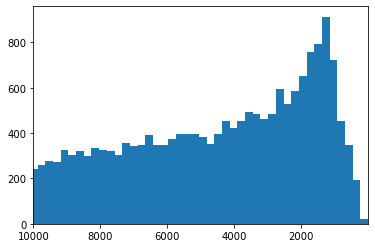

In [137]:
fig, ax = plt.subplots(1,1)
# fig.set_figheight(15)
# fig.set_figwidth(15)
# # ax.set_size_inches(10,15)
ax.set_xlim(10000)
ax.rev
ax.hist(df.palabras.values, bins=10000)

# data['pm2.5'].hist(bins=1000,grid=False)
# ax.set_xlabel("Palabras", fontsize=15)
# ax.set_ylabel("Documentos",fontsize=15)
plt.show()

In [139]:
np.argmax(df.palabras.values)

33328

In [145]:
print(df.iloc[np.argmax(df.palabras.values)].LINK)

https://www.corteconstitucional.gov.co/Relatoria/1996/C-037-96.htm


In [146]:
from bs4 import BeautifulSoup

In [148]:
main_soup = BeautifulSoup(df.iloc[np.argmax(df.palabras.values)].DOCUMENT, 'lxml')

In [149]:
main_soup.text

'LEY ESTATUTARIA JUSTICIA\n\n\n'

In [150]:
with open("sentencia_sucia.txt", "w") as f:
    f.write(df.iloc[np.argmax(df.palabras.values)].DOCUMENT)

In [35]:
X = ['mi mamá me mima', 'mi mamá me ama', 'amo a mi mamá']

In [36]:
from sklearn.feature_extraction.text import CountVectorizer

In [37]:
vec = CountVectorizer(ngram_range=(1,3))
vec.fit(X)

CountVectorizer(ngram_range=(1, 3))

In [39]:
vec.vocabulary_

{'mi': 11,
 'mamá': 4,
 'me': 8,
 'mima': 14,
 'mi mamá': 12,
 'mamá me': 5,
 'me mima': 10,
 'mi mamá me': 13,
 'mamá me mima': 7,
 'ama': 0,
 'me ama': 9,
 'mamá me ama': 6,
 'amo': 1,
 'amo mi': 2,
 'amo mi mamá': 3}